In [17]:
import pickle
import jax

import matplotlib.pyplot as plt
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
from scipy.stats import gaussian_kde
import plotly.express as px
import pandas as pd
import pickle
tfd = tfp.distributions

In [18]:
def get_data(file_name):
    with open(file_name,'rb') as f:
        all_data = pickle.load(f)
    samples = all_data['samples']
    alpha_prior = all_data['prior']['alpha']
    beta_prior = all_data['prior']['beta']
    return samples, alpha_prior, beta_prior

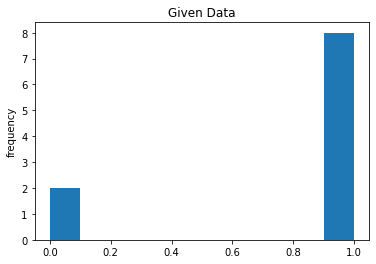

In [19]:
samples, alpha_prior, beta_prior = get_data("../../data/coin_toss")
plt.hist(samples)
plt.ylabel("frequency")
plt.title("Given Data")
plt.show()

In [20]:
samples,alpha_prior,beta_prior = get_data("../../data/coin_toss")
x = jnp.linspace(0,1,100)
one= jnp.sum(samples==1).astype('float32')
zero= jnp.sum(samples==0).astype('float32')
true_post_dist = tfd.Beta(alpha_prior+one,beta_prior+zero)
true_post_pdf = true_post_dist.prob(x)

In [21]:
with open('results_data/coin_toss_VI_Ajax_result','rb') as f:
    variational  = pickle.load(f)
ajax_vi_pdf = jnp.exp(variational.log_prob({"theta":x}))

In [22]:
with open('results_data/MCMC_BlackJAX','rb') as black_f:
    black_samples = pickle.load(black_f)
kde_black = gaussian_kde(black_samples,bw_method=0.3)
pdf_black = kde_black(x)

In [23]:
with open('results_data/coin_toss_laplace_result','rb') as f:
    laplace_normal  = pickle.load(f)
laplace_pdf = laplace_normal.prob(x)

In [24]:
all_pdfs = jnp.array([true_post_pdf,ajax_vi_pdf,pdf_black,laplace_pdf]).reshape((-1))
all_labels = ["True Posterior"]*x.shape[0]+["Ajax VI estimate"]*x.shape[0]+["Blackjax rmh estimate"]*x.shape[0]+["Laplace approximation"]*x.shape[0]
x_repeated = jnp.tile(x,4)
to_df = {
    "theta":x_repeated,
    "PDF":all_pdfs,
    "label": all_labels

}
df = pd.DataFrame(to_df)

fig = px.line(to_df,"theta","PDF",color="label") 
fig.write_html("coin_toss_results.html")
fig.show()